In [24]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table, hstack
from scipy.stats import ks_2samp, beta

import math
import mpl_style
import csv
import hex_scatter as hs

H0 = 70.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [25]:
#loading in data from lookup tables

hdulist1 = fits.open('../lookup_redpas_cut.fits') #red and passive galaxies 
redpas_data = hdulist1[1].data
redpas_ind = redpas_data['redpas_ind'] #index of red and passive galaxies in all_data
redpas_pfeatures = redpas_data['redpas_pfeatures'] #the rest are arrays of tuples for the attribute of the type of galaxy
redpas_psmooth = redpas_data['redpas_psmooth'] #the first element of the tuple is the value, and the second is whether its a satellite or central
redpas_color = redpas_data['redpas_color']
redpas_sfr = redpas_data['redpas_sfr']
redpas_mr = redpas_data['redpas_mr']
redpas_mass = redpas_data['redpas_mass']
redpas_galnum = redpas_data['redpas_galnum']

hdulist2 = fits.open('../lookup_redact_cut.fits')
redact_data = hdulist2[1].data
redact_ind = redact_data['redact_ind']
redact_pfeatures = redact_data['redact_pfeatures']
redact_psmooth = redact_data['redact_psmooth']
redact_color = redact_data['redact_color']
redact_sfr = redact_data['redact_sfr']
redact_mr = redact_data['redact_mr']
redact_mass = redact_data['redact_mass']
redact_galnum = redact_data['redact_galnum']

hdulist3 = fits.open('../lookup_bluact_cut.fits')
bluact_data = hdulist3[1].data
bluact_ind = bluact_data['bluact_ind']
bluact_pfeatures = bluact_data['bluact_pfeatures']
bluact_psmooth = bluact_data['bluact_psmooth']
bluact_color = bluact_data['bluact_color']
bluact_sfr = bluact_data['bluact_sfr']
bluact_mr = bluact_data['bluact_mr']
bluact_mass = bluact_data['bluact_mass']
bluact_galnum = bluact_data['bluact_galnum']

hdulist4 = fits.open('../lookup_all_cut.fits')
all_data = hdulist4[1].data
halo_mass = all_data['halo_mass'] #in units of log(Mhalo/(Msun/h))
pfeatures = all_data['pfeatures']
psmooth = all_data['psmooth']
color = all_data['color']
ssfr = all_data['ssfr']
M_r = all_data['M_r']
mass = all_data['mass']
z = all_data['z']
centsat = all_data['centsat']
#galaxy_num = all_data['galaxy_num']
#group_num = all_data['group_num']

hdulist5 = fits.open('../lookup_spiral_cut.fits')
spiral_data = hdulist5[1].data
spiral_ind = spiral_data['spiral_ind']

hdulist6 = fits.open('../lookup_int_cut.fits')
int_data = hdulist6[1].data
int_ind = int_data['int_ind']

hdulist7 = fits.open('../lookup_smooth_cut.fits')
smooth_data = hdulist7[1].data
smooth_ind = smooth_data['smooth_ind']

group_list = {}
with open('../lookup_group_cut.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        introw = [int(i) for i in row]
        group_list[introw[0]] = introw[1:]

In [4]:
#creates group and galaxy catalogs
group_nums = []
cent_ssfr = []
cent_sfing = []
cent_pfeat = []
cent_mr = []
cent_mass = []
halo_mass_group = []
sf_frac = []
spiral_frac = []
smooth_frac = []
gal_num = []

for group, group_gals in group_list.iteritems():
    if len(group_gals) > 1: #remove single galaxy groups
        has_central = False
        sat_spiral = 0
        sat_smooth = 0
        sat_sfing = 0
        sat_num = 0
        
        for gal in group_gals: #now loop through these galaxies
            ind = np.where(all_data['galaxy_num'] == gal) #index to use in other arrays for this galaxy
            if centsat[ind[0][0]] == 1: #if its a central galaxy
                cent_ssfr.append(ssfr[ind[0][0]])
                cent_pfeat.append(pfeatures[ind[0][0]])
                cent_mr.append(M_r[ind[0][0]])
                halo_mass_group.append(halo_mass[ind[0][0]])
                cent_mass.append(mass[ind[0][0]])
                has_central = True
            else: #satellite galaxy
                sat_num += 1
                if pfeatures[ind[0][0]] >= 0.8:
                    sat_spiral += 1
                if pfeatures[ind[0][0]] <= 0.2:
                    sat_smooth += 1
                if ssfr[ind[0][0]] > (-10 + 0.094*(M_r[ind[0][0]] + 15)):
                    sat_sfing += 1

        if has_central == True:
            sf_frac.append(sat_sfing/sat_num)
            spiral_frac.append(sat_spiral/sat_num)
            smooth_frac.append(sat_smooth/sat_num)
            gal_num.append(sat_num+1)
            group_nums.append(group)
            
            active_line = -10 + 0.094*(cent_mr[-1] + 15)
            if cent_ssfr[-1] >= active_line:
                cent_sfing.append(True)
            else:
                cent_sfing.append(False)
group_table = Table([group_nums, gal_num, halo_mass_group, cent_ssfr, cent_sfing, cent_pfeat, cent_mass, sf_frac, spiral_frac, smooth_frac],
                    names=('group_num', 'n_gal', 'halo_mass', 'cent_ssfr', 'sfing_central', 'cent_pfeat', 'cent_mass', 'sat_sf_frac', 'sat_spiral_frac', 'sat_smooth_frac'))


In [5]:
#add group data to individual galaxies in galaxy_data

n_gal = []
cent_ssfr = []
SFing_central = []
central_pfeat = []
cent_mass = []
sat_SF_frac = []
sat_spiral_frac = []
sat_smooth_frac = []

for g in range(len(all_data)): #loop thru galaxies
    ind = np.where(group_table['group_num'] == all_data['group_num'][g])[0]
    n_gal.append(group_table['n_gal'][ind])
    cent_ssfr.append(group_table['cent_ssfr'][ind])
    SFing_central.append(group_table['sfing_central'][ind])
    central_pfeat.append(group_table['cent_pfeat'][ind])
    cent_mass.append(group_table['cent_mass'][ind])
    sat_SF_frac.append(group_table['sat_sf_frac'][ind])
    sat_spiral_frac.append(group_table['sat_spiral_frac'][ind])
    sat_smooth_frac.append(group_table['sat_smooth_frac'][ind])
    
group_data_add = Table([n_gal, cent_ssfr, SFing_central, central_pfeat, cent_mass, sat_SF_frac, sat_spiral_frac, sat_smooth_frac],
                                   names=('n_gal', 'cent_ssfr', 'sfing_central', 'cent_pfeat', 'cent_mass', 'sat_sf_frac', 'sat_spiral_frac', 'sat_smooth_frac'))
all_data = Table(all_data)
galaxy_table = hstack([all_data, group_data_add])

In [26]:
#this cell creates fraction of galaxy type plots, split by central and satellite

def plot_fraction(inds, labels, cent_xlim, sat_xlim, halo_mass):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax = [ax1,ax2]
    f.set_figheight(6)
    f.set_figwidth(15)
    
    
    colors = ['b', 'g', 'r']
    markers = ['*', '^', 'o']
    c = 0.95
    halo_mass = np.array(halo_mass)
    
    centorsat = [1,2]
    xlims = [cent_xlim, sat_xlim]
    
    all_norm_hists = []
    all_hists_yerr = []
    for i in range(2): #loop through to create histograms and errors for centrals and satellites
        halo_mass_arrs = []
        for j in range(3): #now loop through to create histograms for each (i.e. spiral, int, smooth)
            ind = [x[0] for x in inds[j] if x[1]==centorsat[i]]
            halo_mass_arrs.append(halo_mass[ind])
    
        all_halo_mass = np.concatenate((halo_mass_arrs[0], halo_mass_arrs[1], halo_mass_arrs[2])) 
        
        all_halo_mass = np.sort(all_halo_mass) #this is for binning by percentile, must remove zero nonphysical halo masses
        i = 0
        n = 0
        while i <= 0:
            i = all_halo_mass[n]
            n += 1
        nonzero_all_halo_mass = all_halo_mass[n-1:]

        bin_edges = np.percentile(nonzero_all_halo_mass, np.linspace(0, 100, 11)) #these bins have an equal number of galaxies in each
        plotpts = [] #plotpts is the midpoint of each histogram bin
        for i in range(len(bin_edges[:-1])):
            plotpts.append(bin_edges[i] + (bin_edges[i+1]-bin_edges[i])/2)

        hists = []
        for j in range(3): #loop thru again to create histograms
            hist, bins = np.histogram(halo_mass_arrs[j], bin_edges)
            hists.append(hist)
        all_hist = hists[0] + hists[1] + hists[2]
        print(all_hist)
        norm_hist_type = []
        hist_yerr_type = []
        for j in range(3): #loop through yet again to normalize histograms and make errors
            norm_hist = hists[j]/all_hist
            p_lower = beta.ppf((1-c)/2.,hists[j]+1,all_hist-hists[j]+1)
            p_upper = beta.ppf(1-(1-c)/2.,hists[j]+1,all_hist-hists[j]+1)
            yerr = np.array((norm_hist - p_lower, p_upper - norm_hist))
            hist_yerr_type.append(yerr)
            norm_hist_type.append(norm_hist)
            
        all_norm_hists.append(norm_hist_type)
        all_hists_yerr.append(hist_yerr_type)
    for c in range(2):
        for j in range(len(all_norm_hists[c])):
            ax[c].errorbar(plotpts, all_norm_hists[c][j], all_hists_yerr[c][j], c=colors[j], marker=markers[j], label=labels[j])
        ax[c].set_xlabel(r'$\log (M_{halo}/M_{\odot})$')
        ax[c].set_xlim(xlims[c])
    ax2.legend()
    f.subplots_adjust(wspace=0)
    f.text(0.135, 0.83,'a) centrals',fontsize=20)
    f.text(0.53, 0.83,'b) satellites',fontsize=20)
    return f

[2291 2288 2289 2293 2290 2291 2290 2290 2290 2291]
[1020 1020 1019 1020 1015 1021 1016 1010 1022 1034]


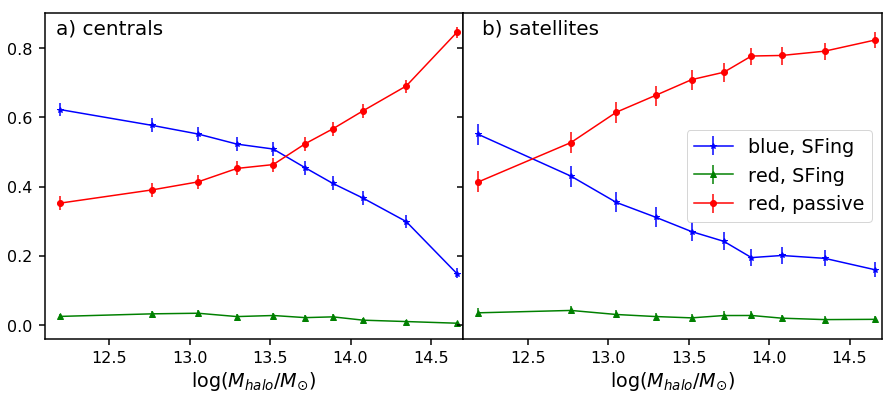

In [29]:
inds = [bluact_ind, redact_ind, redpas_ind]
labels = ['blue, SFing', 'red, SFing', 'red, passive']
cent_xlim = (12.1, 14.7)
sat_xlim = (12.1, 14.7)
plot_fraction(inds, labels, cent_xlim, sat_xlim, halo_mass)
plt.style.use(mpl_style.style1)
plt.show()

[2773 2784 2783 2782 2780 2781 2781 2781 2781 2781]
[1171 1167 1172 1169 1167 1181 1154 1168 1143 1211]


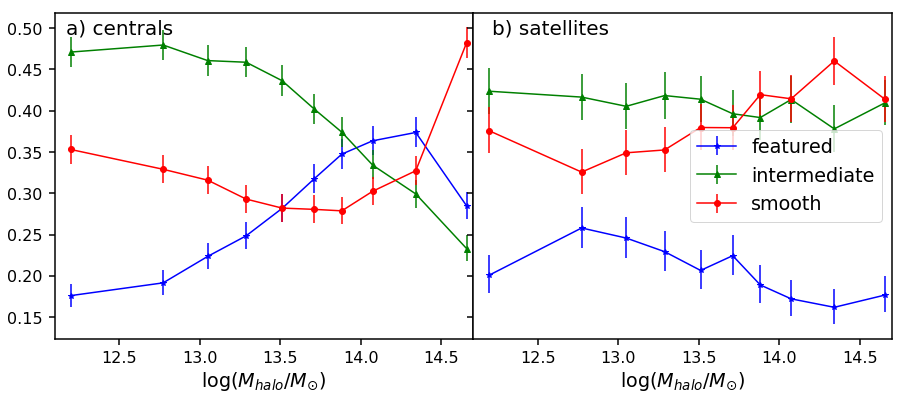

In [31]:
inds = [spiral_ind, int_ind, smooth_ind]
labels = ['featured', 'intermediate', 'smooth']
cent_xlim = (12.1, 14.7)
sat_xlim = (12.1, 14.7)
plot_fraction(inds, labels, cent_xlim, sat_xlim, halo_mass)
plt.style.use(mpl_style.style1)
plt.show()

In [8]:
#this creates a 4 panel plot. The left and right sides are split (e.g. pairs and groups)
#in each plot there are two different histograms ploted (and the total)

def plot_dist(L_arrs, R_arrs, L_cross, R_cross, xlabel, left_label, right_label, plot_labels):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    ax_side = [[ax1, ax3],[ax2, ax4]]
    f.set_figheight(10)
    f.set_figwidth(15)

    colors = ['b', 'r']
    markers = ['*', 'o']
    labels = ['', '']
    all_arrs = [L_arrs, R_arrs]
    cross = [L_cross, R_cross]
    for i in range(2): #looping for left and right side
        ax = ax_side[i]
        
        if i == 0:
            use_label = ['','','']
        else:
            use_label = [plot_labels[0], plot_labels[1], 'all']
        
        arrays = all_arrs[i]
        total = np.concatenate((arrays[0], arrays[1]))
        minum = np.min(total)
        maxum = np.max(total)
        bin_edges = [minum, (minum + cross[i])/2, cross[i], (maxum + cross[i])/2, maxum]
        #bin_edges = np.percentile(total, np.linspace(0,100,10))
        
        plotpts = []
        for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
            plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)
            
        total_hist, bins = np.histogram(total, density=True, bins=bin_edges) #total histogram, bins is throwaway
        ax[0].plot(plotpts, total_hist, c='k', marker='^', linestyle='--', label=use_label[2])
        
        for j in range(2): #looping for two arrays within one side
            norm_hist, bins = np.histogram(arrays[j], density=True, bins=bin_edges)
            unnorm_hist, bins = np.histogram(arrays[j], density=False, bins=bin_edges)
            unnorm_yerr = np.sqrt(unnorm_hist) #sqrt(N) errors
            norm_yerr = (unnorm_yerr/unnorm_hist)*norm_hist
            
            #top histogram plot
            ax[0].errorbar(plotpts, norm_hist, norm_yerr, capsize=8, c=colors[j], marker = markers[j], label=use_label[j])
            ax[0].legend()
            #ax[0].set_ylim(-0.05, 3)
            #bottom difference plot
            ax[1].errorbar(plotpts, norm_hist - total_hist, norm_yerr, capsize=8, c=colors[j], marker = markers[j], label=use_label[j])
            ax[1].axhline(0, c='k')
            ax[1].set_xlabel(xlabel)
            ax[1].set_ylim(-0.38,0.38)
    ax1.set_ylabel('normalized number')
    ax3.set_ylabel('deviation from total')
    
    f.subplots_adjust(wspace=0)
    f.subplots_adjust(hspace=0)

    f.text(0.135, 0.85,'a) '+left_label,fontsize=20)
    f.text(0.55, 0.85,r'b) '+right_label,fontsize=20)
    return f


In [9]:
def mass_histogram(arrs, plot_labels): 
    f = plt.figure(figsize=(10,8))
    for j in range(2):
        hist, bins = np.histogram(arrs[j], density=False)
        plotpts = []
        for b in range(len(bins[:-1])): #creating points to plot - midpoints of bins
            plotpts.append(bins[b] + (bins[b+1]-bins[b])/2)
        plt.semilogy(plotpts, hist, marker='o', label=plot_labels[j])
    plt.xlabel(r'$\log (M/M_{\odot})$')
    plt.ylabel('number')
    plt.legend()

In [13]:
#cell initializing different indices for use later
#group_table indices
pair_ind = np.where(group_table['n_gal'] == 2)[0]
group_ind = np.where(group_table['n_gal'] > 2)[0]

high_sf_ind = np.where(group_table['sat_sf_frac'] >= 0.5)
low_sf_ind = np.where(group_table['sat_sf_frac'] < 0.5)

spiral_ind = np.where(group_table['sat_spiral_frac'] >= 0.5)[0]
smooth_ind = np.where(group_table['sat_smooth_frac'] >= 0.5)[0]
int_ind = np.intersect1d(np.where(group_table['sat_spiral_frac'] < 0.5)[0], np.where(group_table['sat_smooth_frac'] < 0.5)[0])

high_mass_halo_ind = np.where(group_table['halo_mass'] >= 12.5)[0]
low_mass_halo_ind = np.where(group_table['halo_mass'] < 12.5)[0]

high_mass_cent_ind = np.where(group_table['cent_mass'] >= 10)[0]
low_mass_cent_ind = np.where(group_table['cent_mass'] < 10)[0]

sf_cent_ind = np.where(group_table['sfing_central'] == True)[0]
passive_cent_ind = np.where(group_table['sfing_central'] == False)[0]

#galaxy_table indices
mass_val_ind = np.where(galaxy_table['mass'] > 0)[0] #remove galaxies without measured mass

pair_ind_gal = np.where(galaxy_table['n_gal'] == 2)[0]
group_ind_gal = np.where(galaxy_table['n_gal'] > 2)[0]

spiral_ind_gal = np.where(galaxy_table['cent_pfeat'] >= 0.8)[0]
smooth_ind_gal = np.where(galaxy_table['cent_pfeat'] <= 0.2)[0]

sf_cent_ind_gal = np.where(galaxy_table['sfing_central'] == True)[0]
passive_cent_ind_gal = np.where(galaxy_table['sfing_central'] == False)[0]

high_mass_halo_ind_gal = np.where(galaxy_table['halo_mass'] >= 12.5)[0]
low_mass_halo_ind_gal = np.where(galaxy_table['halo_mass'] < 12.5)[0]

high_mass_cent_ind_gal = np.where(group_table['cent_mass'] >= 10)[0]
low_mass_cent_ind_gal = np.where(group_table['cent_mass'] < 10)[0]

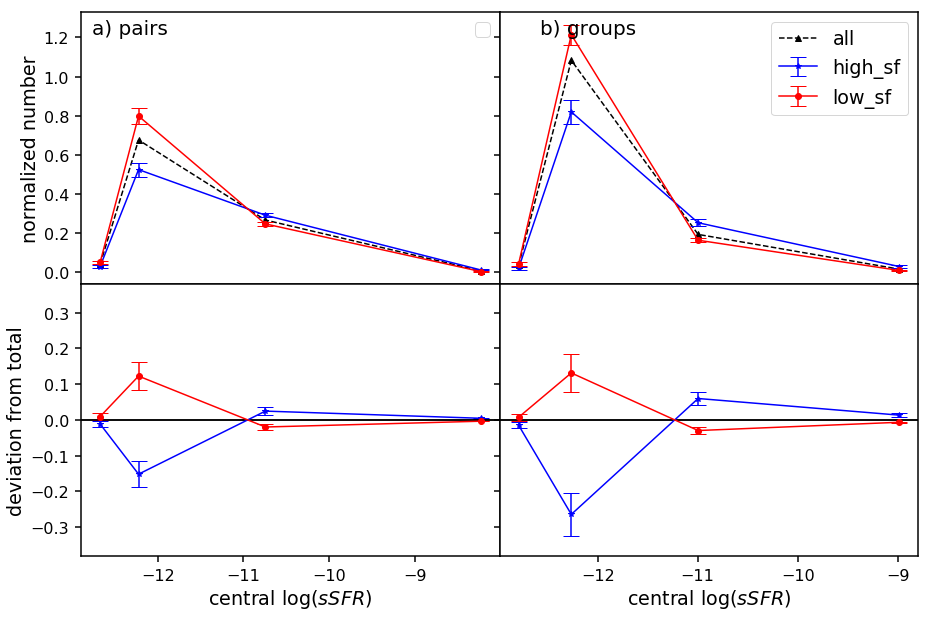

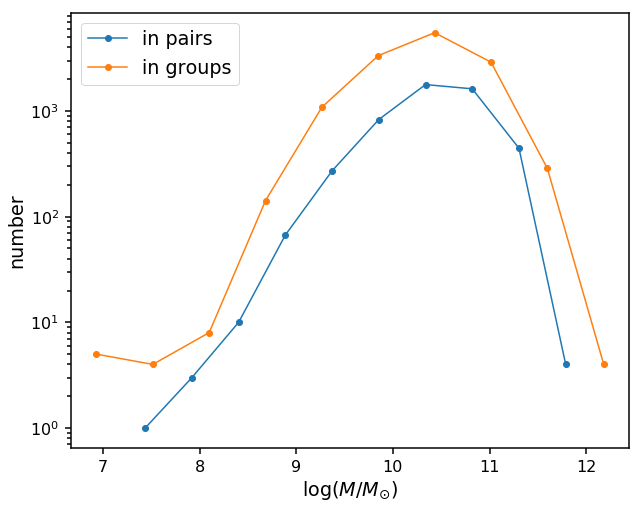

In [32]:
high_sf_pair_ind = np.intersect1d(pair_ind, high_sf_ind)
low_sf_pair_ind = np.intersect1d(pair_ind, low_sf_ind)

high_sf_group_ind = np.intersect1d(group_ind, high_sf_ind)
low_sf_group_ind = np.intersect1d(group_ind, low_sf_ind)

low_sf_pair_cent_ssfr = group_table['cent_ssfr'][low_sf_pair_ind]
high_sf_pair_cent_ssfr = group_table['cent_ssfr'][high_sf_pair_ind]

low_sf_group_cent_ssfr = group_table['cent_ssfr'][low_sf_group_ind]
high_sf_group_cent_ssfr = group_table['cent_ssfr'][high_sf_group_ind]

L_arrs = [high_sf_pair_cent_ssfr, low_sf_pair_cent_ssfr]
R_arrs = [high_sf_group_cent_ssfr, low_sf_group_cent_ssfr]
labels = ['high_sf', 'low_sf']

plot_dist(L_arrs, R_arrs,-12,-12,'central '+r'$\log(sSFR)$', 'pairs', 'groups', labels)

pair_mass_ind = np.intersect1d(pair_ind_gal, mass_val_ind)
group_mass_ind = np.intersect1d(group_ind_gal, mass_val_ind)

mass_histogram([galaxy_table['mass'][pair_mass_ind], galaxy_table['mass'][group_mass_ind]], ['in pairs', 'in groups'])

plt.style.use(mpl_style.style1)
plt.show()

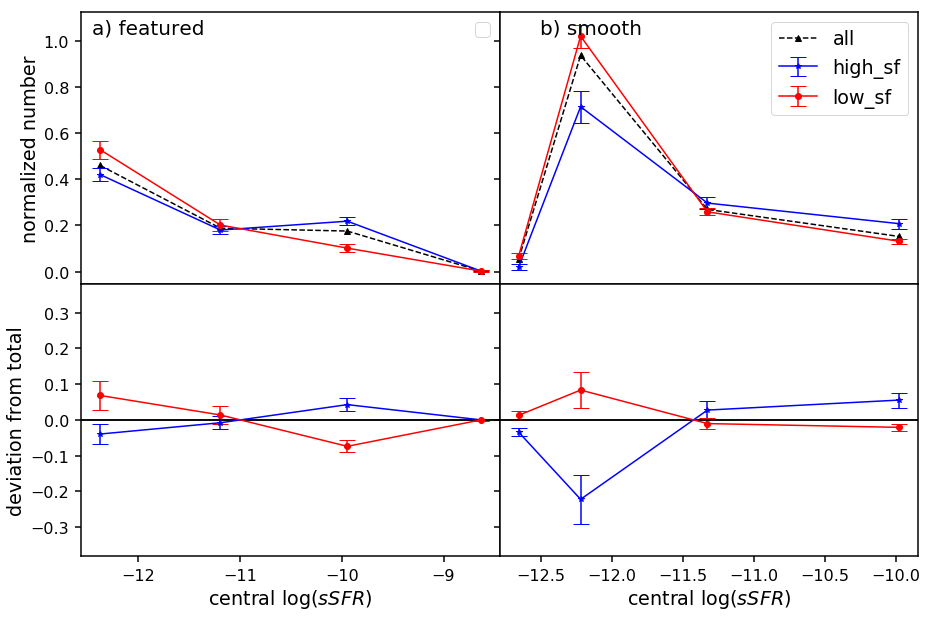

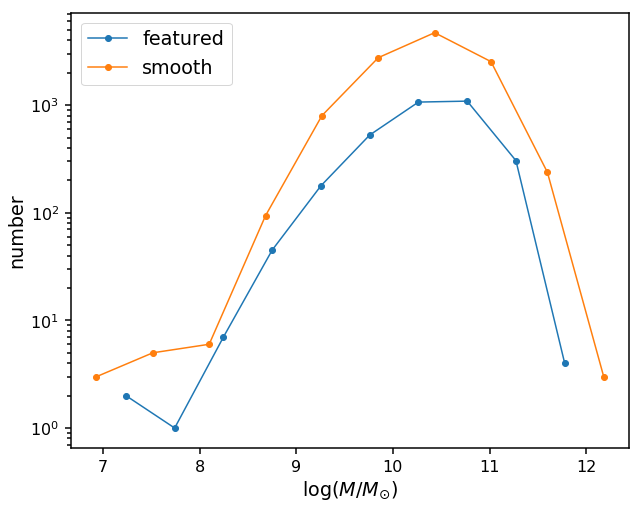

In [14]:
high_sf_spiral_ind = np.intersect1d(spiral_ind, high_sf_ind)
low_sf_spiral_ind = np.intersect1d(spiral_ind, low_sf_ind)

high_sf_smooth_ind = np.intersect1d(smooth_ind, high_sf_ind)
low_sf_smooth_ind = np.intersect1d(smooth_ind, low_sf_ind)

low_sf_spiral_cent_ssfr = group_table['cent_ssfr'][low_sf_spiral_ind]
high_sf_spiral_cent_ssfr = group_table['cent_ssfr'][high_sf_spiral_ind]

low_sf_smooth_cent_ssfr = group_table['cent_ssfr'][low_sf_smooth_ind]
high_sf_smooth_cent_ssfr = group_table['cent_ssfr'][high_sf_smooth_ind]

L_arrs = [high_sf_spiral_cent_ssfr, low_sf_spiral_cent_ssfr]
R_arrs = [high_sf_smooth_cent_ssfr, low_sf_smooth_cent_ssfr]

plot_dist(L_arrs, R_arrs,-10.6,-12,'central '+r'$\log(sSFR)$', 'featured', 'smooth', ['high_sf', 'low_sf'])

spiral_mass_ind = np.intersect1d(spiral_ind_gal, mass_val_ind)
smooth_mass_ind = np.intersect1d(smooth_ind_gal, mass_val_ind)

mass_histogram([galaxy_table['mass'][spiral_mass_ind], galaxy_table['mass'][smooth_mass_ind]], ['featured', 'smooth'])

plt.style.use(mpl_style.style1)
plt.show()

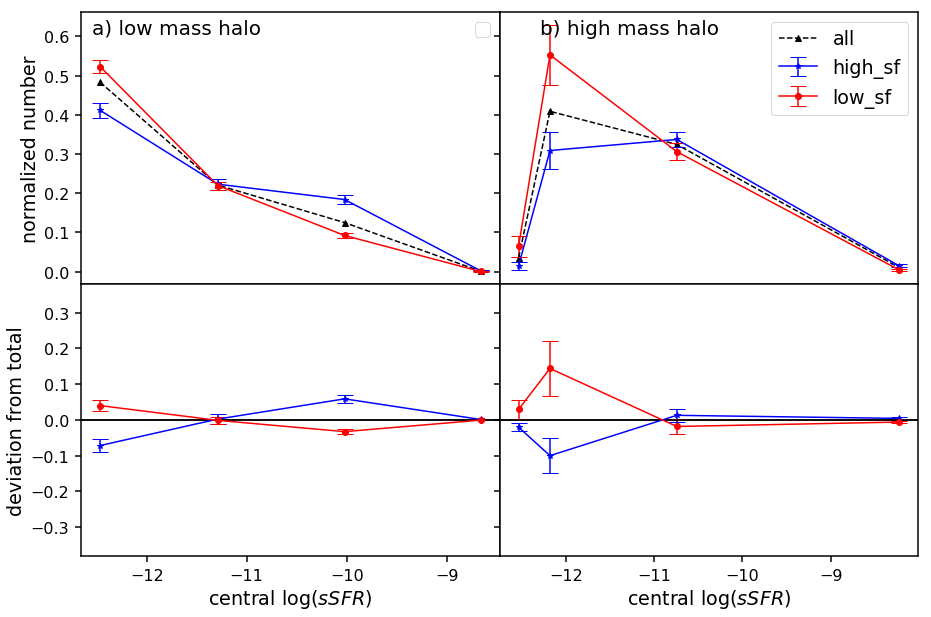

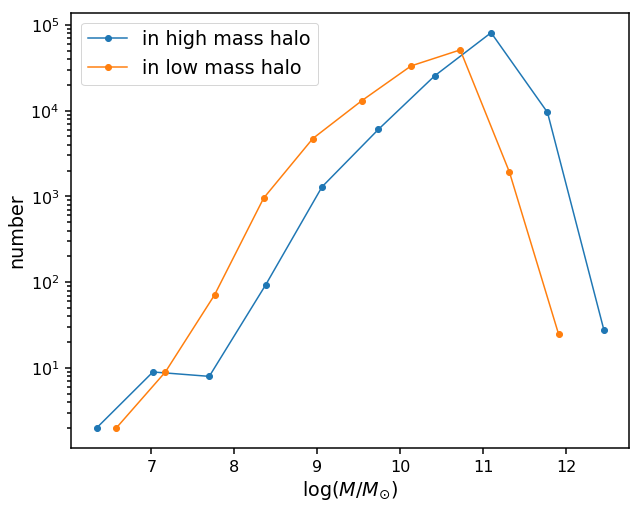

In [15]:
high_sf_high_mass_halo_ind = np.intersect1d(high_mass_halo_ind, high_sf_ind)
low_sf_high_mass_halo_ind = np.intersect1d(high_mass_halo_ind, low_sf_ind)

high_sf_low_mass_halo_ind = np.intersect1d(low_mass_halo_ind, high_sf_ind)
low_sf_low_mass_halo_ind = np.intersect1d(low_mass_halo_ind, low_sf_ind)

low_sf_high_mass_halo_cent_ssfr = group_table['cent_ssfr'][low_sf_high_mass_halo_ind]
high_sf_high_mass_halo_cent_ssfr = group_table['cent_ssfr'][high_sf_high_mass_halo_ind]

low_sf_low_mass_halo_cent_ssfr = group_table['cent_ssfr'][low_sf_low_mass_halo_ind]
high_sf_low_mass_halo_cent_ssfr = group_table['cent_ssfr'][high_sf_low_mass_halo_ind]

L_arrs = [high_sf_high_mass_halo_cent_ssfr, low_sf_high_mass_halo_cent_ssfr]
R_arrs = [high_sf_low_mass_halo_cent_ssfr, low_sf_low_mass_halo_cent_ssfr]

plot_dist(L_arrs, R_arrs,-10.7,-12,'central '+r'$\log(sSFR)$', 'low mass halo', 'high mass halo', ['high_sf', 'low_sf'])

high_mass_halo_mass_ind = np.intersect1d(high_mass_halo_ind_gal, mass_val_ind)
low_mass_halo_mass_ind = np.intersect1d(low_mass_halo_ind_gal, mass_val_ind)

mass_histogram([galaxy_table['mass'][high_mass_halo_mass_ind], galaxy_table['mass'][low_mass_halo_mass_ind]], ['in high mass halo', 'in low mass halo'])

plt.style.use(mpl_style.style1)
plt.show()

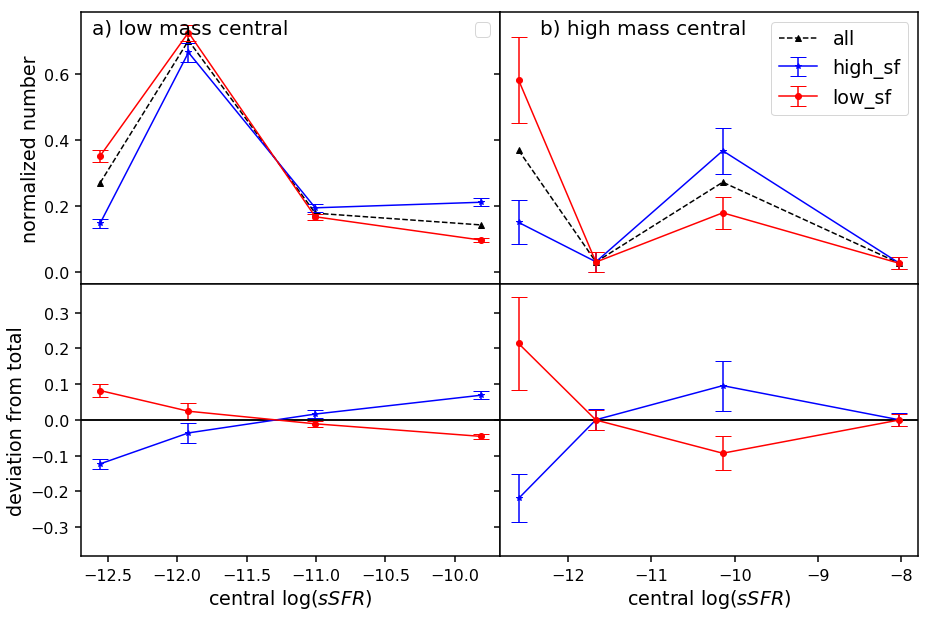

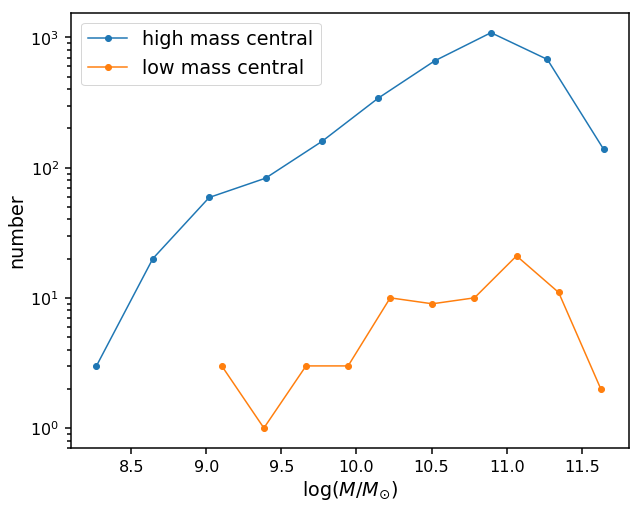

In [16]:
high_sf_high_mass_cent_ind = np.intersect1d(high_mass_cent_ind, high_sf_ind)
low_sf_high_mass_cent_ind = np.intersect1d(high_mass_cent_ind, low_sf_ind)

high_sf_low_mass_cent_ind = np.intersect1d(low_mass_cent_ind, high_sf_ind)
low_sf_low_mass_cent_ind = np.intersect1d(low_mass_cent_ind, low_sf_ind)

low_sf_high_mass_cent_cent_ssfr = group_table['cent_ssfr'][low_sf_high_mass_cent_ind]
high_sf_high_mass_cent_cent_ssfr = group_table['cent_ssfr'][high_sf_high_mass_cent_ind]

low_sf_low_mass_cent_cent_ssfr = group_table['cent_ssfr'][low_sf_low_mass_cent_ind]
high_sf_low_mass_cent_cent_ssfr = group_table['cent_ssfr'][high_sf_low_mass_cent_ind]

L_arrs = [high_sf_high_mass_cent_cent_ssfr, low_sf_high_mass_cent_cent_ssfr]
R_arrs = [high_sf_low_mass_cent_cent_ssfr, low_sf_low_mass_cent_cent_ssfr]

plot_dist(L_arrs, R_arrs,-11.6,-11.2,'central '+r'$\log(sSFR)$', 'low mass central', 'high mass central', ['high_sf', 'low_sf'])

high_mass_cent_mass_ind = np.intersect1d(high_mass_cent_ind_gal, mass_val_ind)
low_mass_cent_mass_ind = np.intersect1d(low_mass_cent_ind_gal, mass_val_ind)

mass_histogram([galaxy_table['mass'][high_mass_cent_mass_ind], galaxy_table['mass'][low_mass_cent_mass_ind]], ['high mass central', 'low mass central'])

plt.style.use(mpl_style.style1)
plt.show()

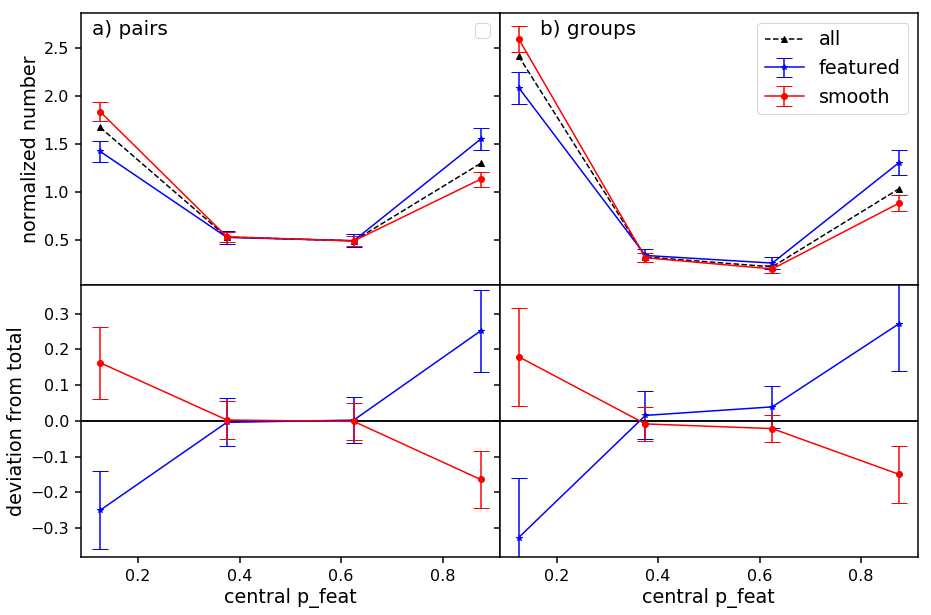

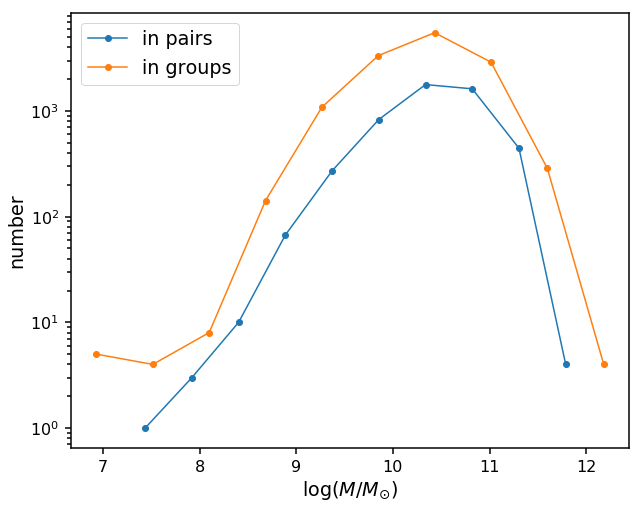

In [129]:
spiral_pair_ind = np.intersect1d(pair_ind, spiral_ind)
smooth_pair_ind = np.intersect1d(pair_ind, smooth_ind)
int_pair_ind = np.intersect1d(pair_ind, int_ind)

spiral_group_ind = np.intersect1d(group_ind, spiral_ind)
smooth_group_ind = np.intersect1d(group_ind, smooth_ind)
int_group_ind = np.intersect1d(group_ind, int_ind)

smooth_pair_cent_pfeat = group_table['cent_pfeat'][smooth_pair_ind]
spiral_pair_cent_pfeat = group_table['cent_pfeat'][spiral_pair_ind]
int_pair_cent_pfeat = group_table['cent_pfeat'][int_pair_ind]

smooth_group_cent_pfeat = group_table['cent_pfeat'][smooth_group_ind]
spiral_group_cent_pfeat = group_table['cent_pfeat'][spiral_group_ind]
int_group_cent_pfeat = group_table['cent_pfeat'][int_group_ind]

L_arrs = [spiral_pair_cent_pfeat, smooth_pair_cent_pfeat, int_pair_cent_pfeat]
R_arrs = [spiral_group_cent_pfeat, smooth_group_cent_pfeat, int_group_cent_pfeat]

plot_dist(L_arrs, R_arrs,0.5,0.5,'central p_feat', 'pairs', 'groups', ['featured', 'smooth'])

pair_mass_ind = np.intersect1d(pair_ind_gal, mass_val_ind)
group_mass_ind = np.intersect1d(group_ind_gal, mass_val_ind)

mass_histogram([galaxy_table['mass'][pair_mass_ind], galaxy_table['mass'][group_mass_ind]], ['in pairs', 'in groups'])

plt.style.use(mpl_style.style1)
plt.show()

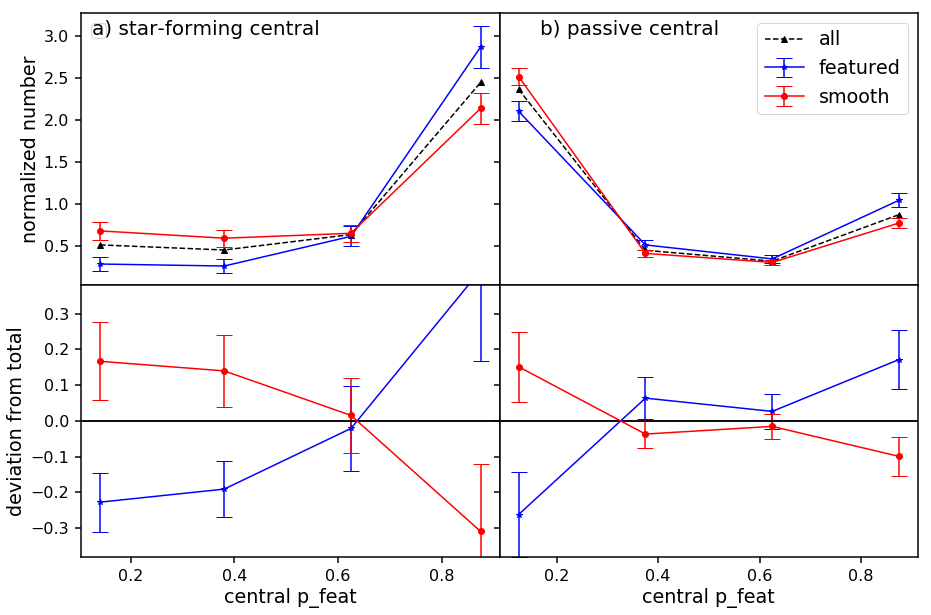

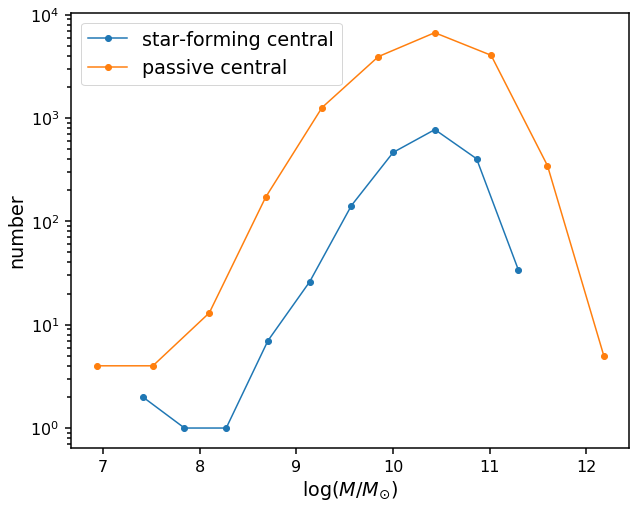

In [128]:
spiral_sf_cent_ind = np.intersect1d(sf_cent_ind, spiral_ind)
smooth_sf_cent_ind = np.intersect1d(sf_cent_ind, smooth_ind)
int_sf_cent_ind = np.intersect1d(sf_cent_ind, int_ind)

spiral_passive_cent_ind = np.intersect1d(passive_cent_ind, spiral_ind)
smooth_passive_cent_ind = np.intersect1d(passive_cent_ind, smooth_ind)
int_passive_cent_ind = np.intersect1d(passive_cent_ind, int_ind)

smooth_sf_cent_cent_pfeat = group_table['cent_pfeat'][smooth_sf_cent_ind]
spiral_sf_cent_cent_pfeat = group_table['cent_pfeat'][spiral_sf_cent_ind]
int_sf_cent_cent_pfeat = group_table['cent_pfeat'][int_sf_cent_ind]

smooth_passive_cent_cent_pfeat = group_table['cent_pfeat'][smooth_passive_cent_ind]
spiral_passive_cent_cent_pfeat = group_table['cent_pfeat'][spiral_passive_cent_ind]
int_passive_cent_cent_pfeat = group_table['cent_pfeat'][int_passive_cent_ind]

L_arrs = [spiral_sf_cent_cent_pfeat, smooth_sf_cent_cent_pfeat, int_sf_cent_cent_pfeat]
R_arrs = [spiral_passive_cent_cent_pfeat, smooth_passive_cent_cent_pfeat, int_passive_cent_cent_pfeat]

plot_dist(L_arrs, R_arrs,0.5,0.5,'central p_feat', 'star-forming central', 'passive central', ['featured', 'smooth'])

sf_cent_mass_ind = np.intersect1d(sf_cent_ind_gal, mass_val_ind)
passive_cent_mass_ind = np.intersect1d(passive_cent_ind_gal, mass_val_ind)

mass_histogram([galaxy_table['mass'][sf_cent_mass_ind], galaxy_table['mass'][passive_cent_mass_ind]], ['star-forming central', 'passive central'])

plt.style.use(mpl_style.style1)
plt.show()